# AutoML Forecasting with Azure ML


<img src='https://github.com/retkowsky/images/blob/master/AzureMLservicebanniere.png?raw=true'>

This python notebook uses Azure ML service and its AUTOML features to automatically generate a time series model.
We are using a time series dataset with daily observations.
> https://docs.microsoft.com/en-us/python/api/overview/azure/ml/intro?view=azure-ml-py

In [1]:
# Version Python 3.6 du notebook
import sys
print("Version Python:",sys.version)

Version Python: 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]


In [2]:
import datetime
print("Date :" , datetime.datetime.now())

Date : 2020-05-18 12:57:24.865578


## 1. Paramétrage


In [3]:
import azureml.core
import pandas as pd
import numpy as np
import logging
import warnings

from pandas.tseries.frequencies import to_offset

# Squash warning messages for cleaner output in the notebook
warnings.showwarning = lambda *args, **kwargs: None

from azureml.core.workspace import Workspace
from azureml.core.experiment import Experiment
from azureml.train.automl import AutoMLConfig
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [6]:
import azureml.core
print("Version Azure ML service :", azureml.core.VERSION)

Version Azure ML service : 1.4.0


In [7]:
ws = Workspace.from_config()

# choose a name for the run history container in the workspace
experiment_name = 'Exemple4-automlforecast'
# project folder
project_folder = './sample_projects/workshop4'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Run History Name'] = experiment_name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
SDK version,1.4.0
Workspace,workshopAML2020
Resource Group,workshopAML2020-rg
Location,westeurope
Project Directory,./sample_projects/workshop4
Run History Name,Exemple4-automlforecast


## 2. Reading data

In [8]:
mydateparser = lambda x: pd.datetime.strptime(x, "%d/%m/%Y")
data = pd.read_csv("Pollution.csv" , encoding = "iso-8859-1", parse_dates = ['Date'] , 
date_parser = mydateparser)

In [9]:
data

,Date,CO2,Vent,Humidite,NO_Monoxyde_azote,NOX_Oxyde_azote,O3_Ozone,Poussieres,SO2_Dioxyde_de_soufre,Temperature,Direction_vent
0,2019-01-01,0.63,101.64,79.79,117.68,147.46,0.98,14.89,10.73,2.22,2.01
1,2019-01-02,0.62,117.99,78.78,85.94,115.23,0.85,14.65,10.01,2.22,2.07
2,2019-01-03,0.63,114.96,76.95,54.69,83.98,0.98,15.63,8.94,2.43,1.62
3,2019-01-04,0.55,125.77,77.34,39.06,67.87,0.85,14.40,8.94,2.41,2.46
4,2019-01-05,0.47,127.88,80.13,29.30,57.13,0.73,12.70,8.94,1.97,2.53
5,2019-01-06,0.42,132.49,81.18,29.30,54.69,0.85,11.23,8.58,1.78,1.77
6,2019-01-07,0.63,139.61,83.45,38.57,64.45,0.85,8.79,8.58,1.23,1.37
7,2019-01-08,0.46,126.03,84.89,29.30,54.69,0.85,7.08,8.58,1.11,2.87
8,2019-01-09,0.31,126.30,81.23,18.55,42.97,1.34,7.81,7.87,1.64,2.54
9,2019-01-10,0.38,123.92,81.13,14.16,36.62,1.10,9.28,8.58,1.39,1.75


In [10]:
data.columns

Index(['Date', 'CO2', 'Vent', 'Humidite', 'NO_Monoxyde_azote',
       'NOX_Oxyde_azote', 'O3_Ozone', 'Poussieres', 'SO2_Dioxyde_de_soufre',
       'Temperature', 'Direction_vent'],
      dtype='object')

In [11]:
data.dtypes

Date                     datetime64[ns]
CO2                      float64       
Vent                     float64       
Humidite                 float64       
NO_Monoxyde_azote        float64       
NOX_Oxyde_azote          float64       
O3_Ozone                 float64       
Poussieres               float64       
SO2_Dioxyde_de_soufre    float64       
Temperature              float64       
Direction_vent           float64       
dtype: object

## 3. Descriptive statistics

In [12]:
print("Lignes, colonnes :",data.shape)

Lignes, colonnes : (336, 11)


## Statistiques descriptives

In [13]:
data.describe()

,CO2,Vent,Humidite,NO_Monoxyde_azote,NOX_Oxyde_azote,O3_Ozone,Poussieres,SO2_Dioxyde_de_soufre,Temperature,Direction_vent
count,336.00,336.00,336.00,336.00,336.00,336.00,336.00,336.00,336.00,336.00
mean,1.40,130.98,73.87,143.81,173.52,4.29,39.90,28.02,2.45,2.70
std,1.33,53.19,17.33,184.16,195.87,3.70,26.23,14.56,3.40,1.87
min,0.13,2.54,48.05,4.88,15.63,0.73,3.66,7.87,-3.36,0.14
25%,0.49,107.54,57.06,17.58,34.67,1.71,20.39,19.67,-0.27,1.10
50%,0.83,121.85,71.20,51.03,80.32,2.75,33.57,24.32,1.81,2.44
75%,1.91,134.40,91.44,199.82,235.96,6.04,47.06,32.28,4.30,3.95
max,6.70,349.88,99.98,924.80,991.70,17.94,140.14,82.98,11.83,7.98


## Matrice de corrélations

In [14]:
data.corr()

,CO2,Vent,Humidite,NO_Monoxyde_azote,NOX_Oxyde_azote,O3_Ozone,Poussieres,SO2_Dioxyde_de_soufre,Temperature,Direction_vent
CO2,1.00,0.04,0.62,0.97,0.97,-0.30,0.72,0.08,-0.01,-0.62
Vent,0.04,1.00,-0.04,-0.01,0.01,-0.15,0.24,0.02,0.40,-0.17
Humidite,0.62,-0.04,1.00,0.68,0.67,-0.42,0.50,0.02,-0.43,-0.64
NO_Monoxyde_azote,0.97,-0.01,0.68,1.00,1.00,-0.29,0.70,0.02,-0.09,-0.64
NOX_Oxyde_azote,0.97,0.01,0.67,1.00,1.00,-0.31,0.71,0.01,-0.07,-0.65
O3_Ozone,-0.30,-0.15,-0.42,-0.29,-0.31,1.00,-0.28,0.32,0.21,0.69
Poussieres,0.72,0.24,0.50,0.70,0.71,-0.28,1.00,0.23,0.12,-0.55
SO2_Dioxyde_de_soufre,0.08,0.02,0.02,0.02,0.01,0.32,0.23,1.00,0.06,0.26
Temperature,-0.01,0.40,-0.43,-0.09,-0.07,0.21,0.12,0.06,1.00,-0.02
Direction_vent,-0.62,-0.17,-0.64,-0.64,-0.65,0.69,-0.55,0.26,-0.02,1.00


## Graphiques

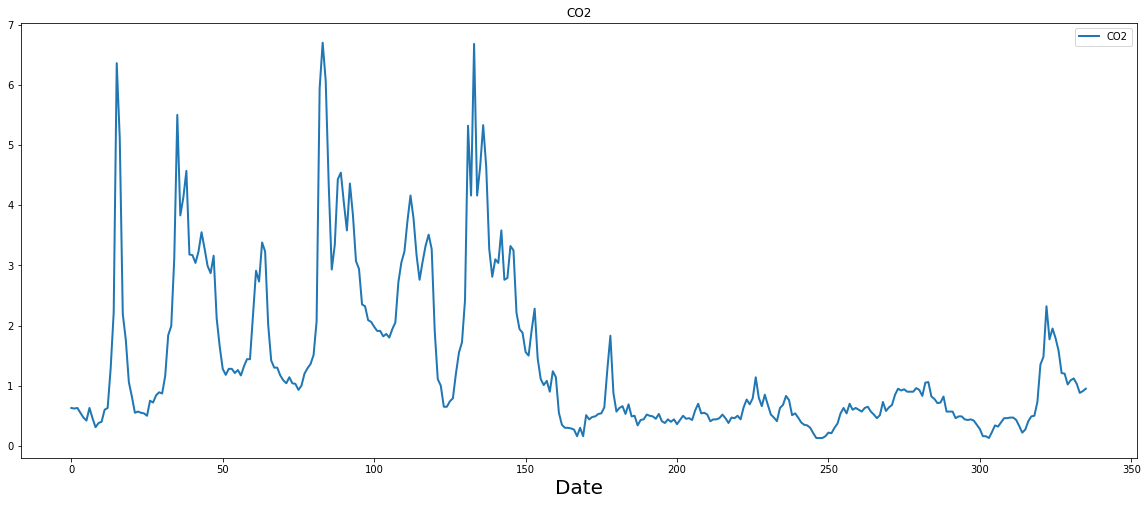

In [15]:
data[['CO2']].plot(figsize=(20,8), linewidth=2, fontsize=10)
plt.title('CO2')
plt.xlabel('Date', fontsize=20);

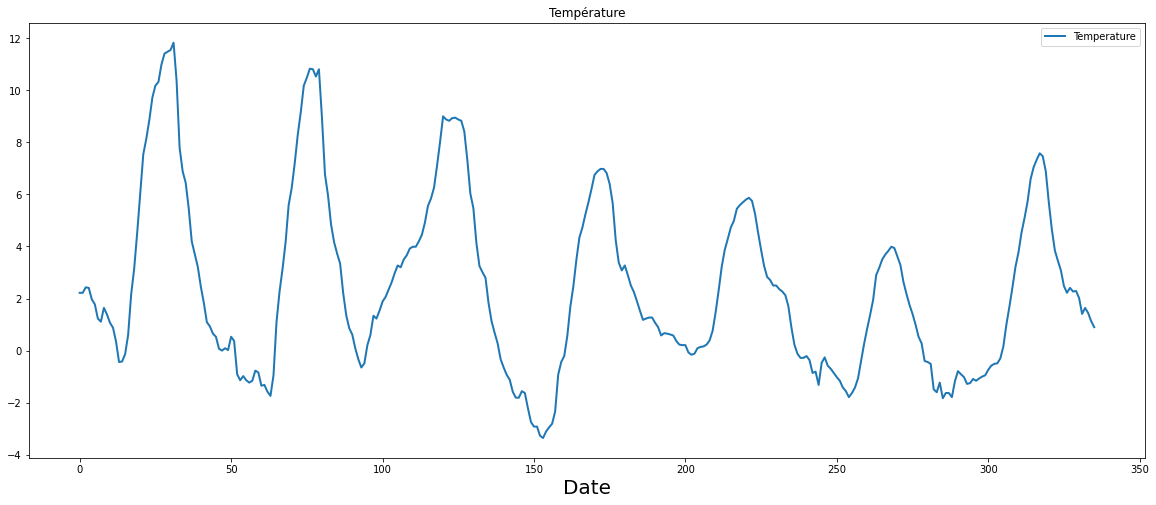

In [16]:
data[['Temperature']].plot(figsize=(20,8), linewidth=2, fontsize=10)
plt.title('Température')
plt.xlabel('Date', fontsize=20);

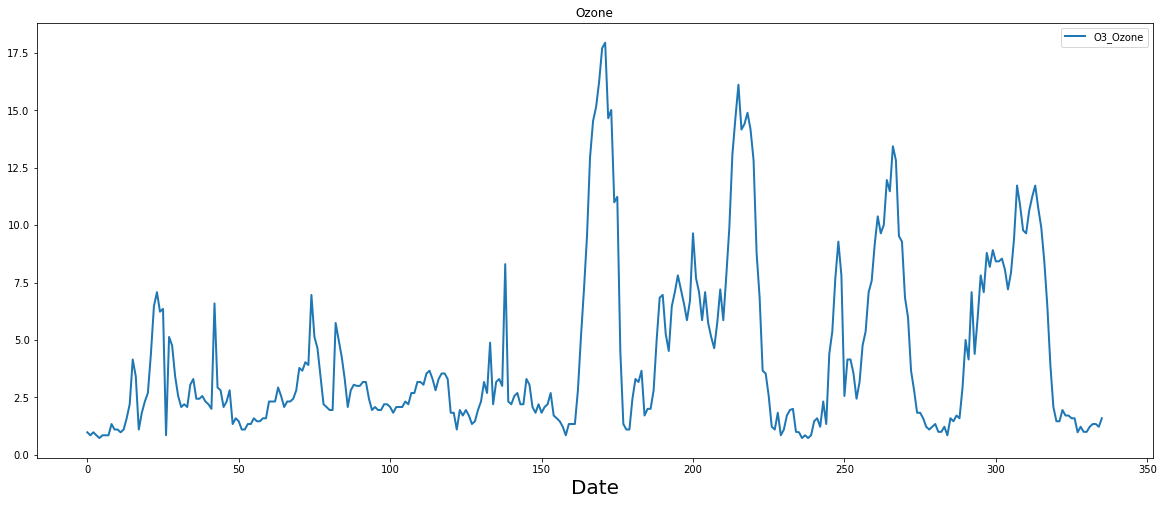

In [17]:
data[['O3_Ozone']].plot(figsize=(20,8), linewidth=2, fontsize=10)
plt.title('Ozone')
plt.xlabel('Date', fontsize=20);

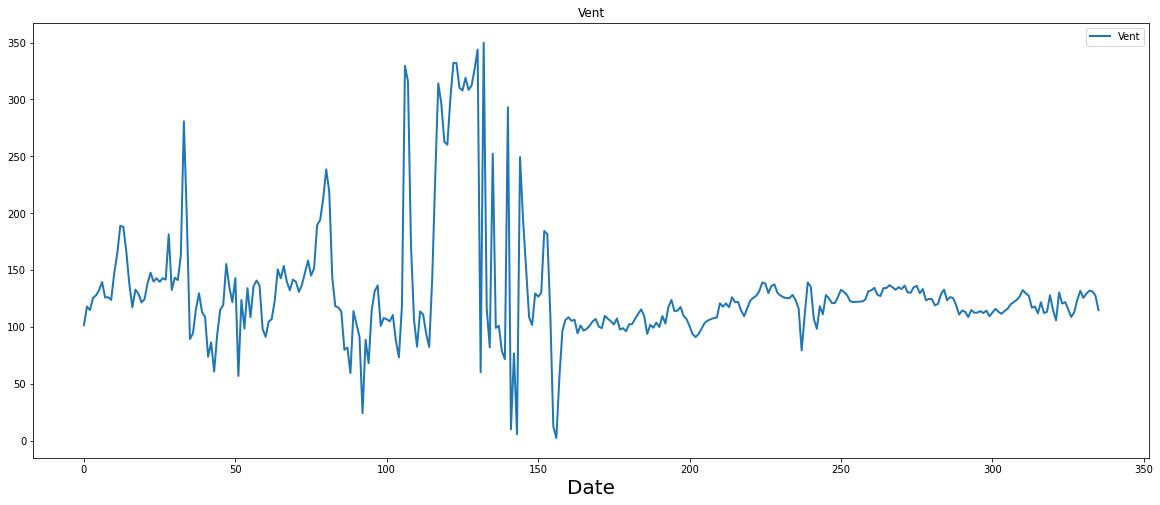

In [18]:
data[['Vent']].plot(figsize=(20,8), linewidth=2, fontsize=10)
plt.title('Vent')
plt.xlabel('Date', fontsize=20);

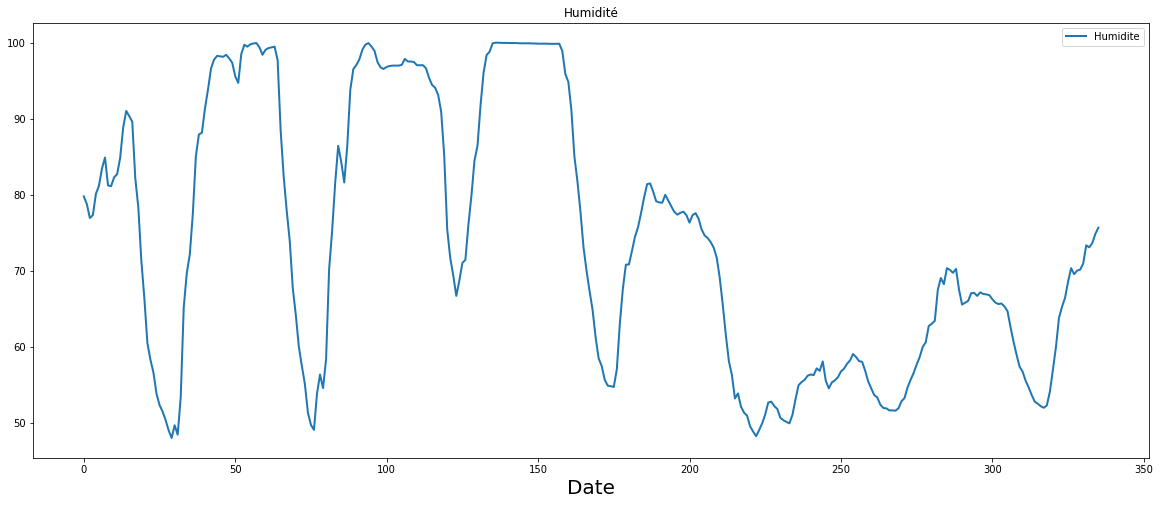

In [19]:
data[['Humidite']].plot(figsize=(20,8), linewidth=2, fontsize=10)
plt.title('Humidité')
plt.xlabel('Date', fontsize=20);

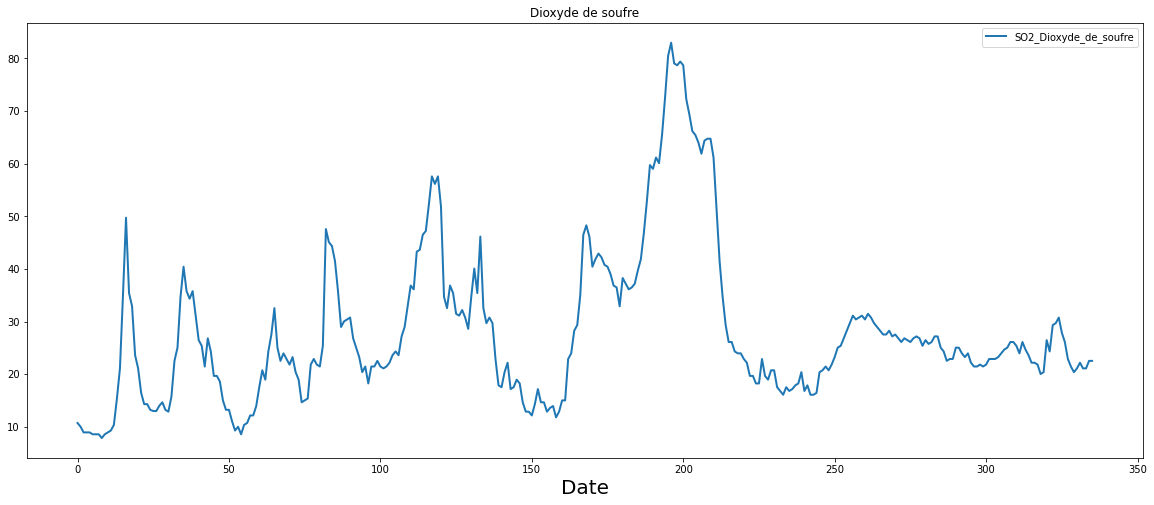

In [20]:
data[['SO2_Dioxyde_de_soufre']].plot(figsize=(20,8), linewidth=2, fontsize=10)
plt.title('Dioxyde de soufre')
plt.xlabel('Date', fontsize=20);

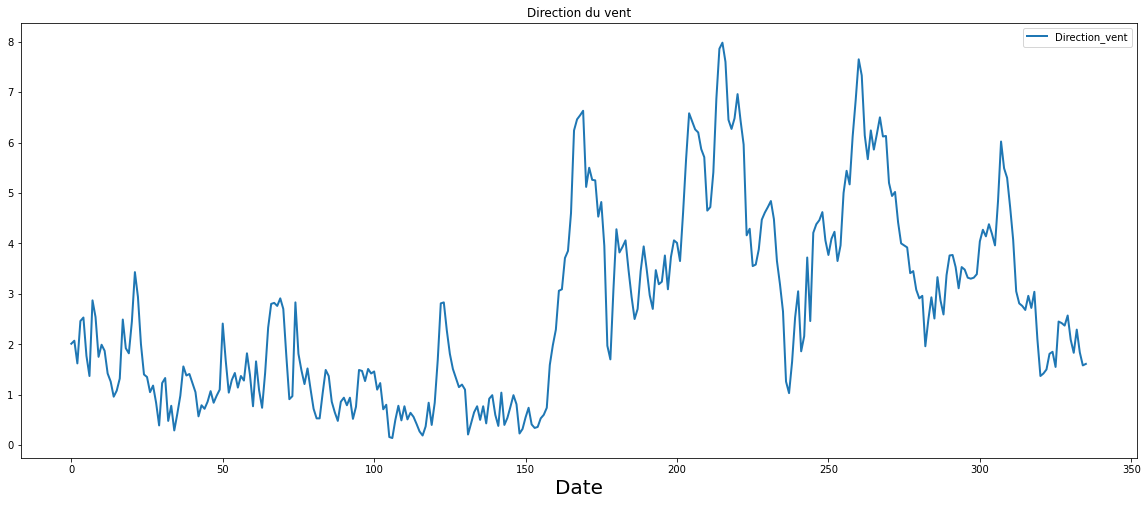

In [21]:
data[['Direction_vent']].plot(figsize=(20,8), linewidth=2, fontsize=10)
plt.title('Direction du vent')
plt.xlabel('Date', fontsize=20);

## 4. AutoML Forecasting
We are going to predict CO2

In [22]:
target_column_name = 'CO2' #Target variable to predict
time_column_name = 'Date'  #Date variable
grain_column_names = []    #Optional. Needed for multiple time series ie location...

<img src="https://azurecomcdn.azureedge.net/mediahandler/acomblog/media/Default/blog/616f2d9f-eb6a-4f3b-af56-cc82197db001.png" height="50" width="600">

## 4.1 Split the data

The first split we make is into train and test sets. Note we are splitting on time.

In [23]:
train = data[data[time_column_name] < '2019-10-01']
test = data[data[time_column_name] >= '2019-10-01']

X_train = train.copy()
y_train = X_train.pop(target_column_name).values

X_test = test.copy()
y_test = X_test.pop(target_column_name).values

print("Training dimensions:")
print(X_train.shape)
print(y_train.shape)
print()
print("Test dimensions:")
print(X_test.shape)
print(y_test.shape)

Training dimensions:
(273, 10)
(273,)

Test dimensions:
(63, 10)
(63,)


## 4.2 Setting forecast maximum horizon 

The forecast horizon is the number of periods into the future that the model should predict.

In [24]:
max_horizon = 30

## 4.3 Azure AutoML specification

Instantiate a AutoMLConfig object. This defines the settings and data used to run the experiment.

|Property|Description|
|-|-|
|**task**|forecasting|
|**primary_metric**|This is the metric that you want to optimize.<br> Forecasting supports the following primary metrics <br><i>spearman_correlation</i><br><i>normalized_root_mean_squared_error</i><br><i>r2_score</i><br><i>normalized_mean_absolute_error</i>
|**iterations**|Number of iterations. In each iteration, Auto ML trains a specific pipeline on the given data|
|**iteration_timeout_minutes**|Time limit in minutes for each iteration.|
|**X**|(sparse) array-like, shape = [n_samples, n_features]|
|**y**|(sparse) array-like, shape = [n_samples, ], targets values.|
|**n_cross_validations**|Number of cross validation splits.|
|**country_or_region**|The country/region used to generate holiday features. These should be ISO 3166 two-letter country/region codes (i.e. 'US', 'GB').|
|**path**|Relative path to the project folder.  AutoML stores configuration files for the experiment under this folder. You can specify a new empty folder. 

> Documentation : https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-auto-train

In [25]:
automl_settings = {
    'time_column_name': time_column_name,
    'max_horizon': max_horizon,
    'target_lags': 12,
    
}

automl_config = AutoMLConfig(task='forecasting',
                             debug_log = 'automl4.log',
                             primary_metric='normalized_root_mean_squared_error',
                             iterations=10,
                             iteration_timeout_minutes = 5,
                             experiment_timeout_minutes = 15,
                             enable_early_stopping=True,
                             X=X_train,
                             y=y_train,
                             n_cross_validations=3,  
                             enable_voting_ensemble=False,
                             enable_stack_ensemble=False,
                             path=project_folder,
                             **automl_settings)

WARNING - The AutoMLConfig inputs you have specified will soon be deprecated. Please use the AutoMLConfig shown in our documentation: https://aka.ms/AutoMLConfig


> Normalized root-mean-square deviation. This value is commonly referred to as the normalized root-mean-square deviation or error ( NRMSD or NRMSE ), and often expressed as a percentage, where lower values indicate less residual variance. https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-auto-train

In [26]:
%%time
local_run = experiment.submit(automl_config, show_output=True)

Running on local machine
Parent Run ID: AutoML_825cf827-e15d-4303-b8c8-7a824ffbe948

Current status: DatasetFeaturization. Beginning to featurize the dataset.


WARNING - Converting non-string tag to string: (forecasting_target_lags: [12])
WARNING - Converting non-string tag to string: (forecasting_target_rolling_window_size: 0)
WARNING - Converting non-string tag to string: (forecasting_max_horizon: 30)


Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Frequency detection
STATUS:       PASSED
DESCRIPTION:  The time series was analyzed, all data points are aligned with detected frequency.

TYPE:         Memory Issues Detection
STATUS:       PASSED
DESCRIPTION:  The se

## Notebook Widget

In [27]:
from azureml.widgets import RunDetails
RunDetails(local_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

## Link to Azure Portal

In [28]:
local_run

Experiment,Id,Type,Status,Details Page,Docs Page
Exemple4-automlforecast,AutoML_825cf827-e15d-4303-b8c8-7a824ffbe948,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


### 4.4 Retrieve the Best Model
Below we select the best pipeline from our iterations. The **get_output** method on automl_classifier returns the best run and the fitted model for the last fit invocation. There are overloads on get_output that allow you to retrieve the best run and fitted model for any logged metric or a particular iteration.

In [29]:
best_run, fitted_model = local_run.get_output()
fitted_model.steps

[('timeseriestransformer',
  TimeSeriesTransformer(featurization_config=None, logger=None,
             pipeline_type=<TimeSeriesPipelineType.FULL: 1>)),
 ('StandardScalerWrapper',
  <azureml.automl.runtime.shared.model_wrappers.StandardScalerWrapper at 0x7f2948315b70>),
 ('ElasticNet',
  ElasticNet(alpha=0.8948421052631579, copy_X=True, fit_intercept=True,
        l1_ratio=0.4268421052631579, max_iter=1000, normalize=False,
        positive=False, precompute=False, random_state=None,
        selection='cyclic', tol=0.0001, warm_start=False))]

In [30]:
fitted_model.get_params

<bound method Pipeline.get_params of ForecastingPipelineWrapper(pipeline=Pipeline(memory=None,
     steps=[('timeseriestransformer', TimeSeriesTransformer(featurization_config=None, logger=None,
           pipeline_type=<TimeSeriesPipelineType.FULL: 1>)), ('StandardScalerWrapper', <azureml.automl.runtime.shared.model_wrappers.StandardScalerWrapper object at 0x7f2948315b70>), ('ElasticNet', Elastic...alse, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False))]),
              stddev=None)>

In [31]:
fitted_model.steps

[('timeseriestransformer',
  TimeSeriesTransformer(featurization_config=None, logger=None,
             pipeline_type=<TimeSeriesPipelineType.FULL: 1>)),
 ('StandardScalerWrapper',
  <azureml.automl.runtime.shared.model_wrappers.StandardScalerWrapper at 0x7f2948315b70>),
 ('ElasticNet',
  ElasticNet(alpha=0.8948421052631579, copy_X=True, fit_intercept=True,
        l1_ratio=0.4268421052631579, max_iter=1000, normalize=False,
        positive=False, precompute=False, random_state=None,
        selection='cyclic', tol=0.0001, warm_start=False))]

### 4.5 View the engineered names for featurized data

In [32]:
fitted_model.named_steps['timeseriestransformer'].get_engineered_feature_names()

['Direction_vent',
 'Direction_vent_WASNULL',
 'Humidite',
 'Humidite_WASNULL',
 'NOX_Oxyde_azote',
 'NOX_Oxyde_azote_WASNULL',
 'NO_Monoxyde_azote',
 'NO_Monoxyde_azote_WASNULL',
 'O3_Ozone',
 'O3_Ozone_WASNULL',
 'Poussieres',
 'Poussieres_WASNULL',
 'SO2_Dioxyde_de_soufre',
 'SO2_Dioxyde_de_soufre_WASNULL',
 'Temperature',
 'Temperature_WASNULL',
 'Vent',
 'Vent_WASNULL',
 'horizon_origin',
 '_automl_target_col_lag12D',
 'half',
 'quarter',
 'month',
 'day',
 'wday',
 'qday']

### 4.6 View the featurization summary

You can also see what featurization steps were performed on different raw features in the user data. For each raw feature in the user data, the following information is displayed:

- Raw feature name
- Number of engineered features formed out of this raw feature
- Type detected
- If feature was dropped
- List of feature transformations for the raw feature

In [33]:
# Get the featurization summary as a list of JSON
featurization_summary = fitted_model.named_steps['timeseriestransformer'].get_featurization_summary()
# View the featurization summary as a pandas dataframe
pd.DataFrame.from_records(featurization_summary)

,Dropped,EngineeredFeatureCount,RawFeatureName,Transformations,TypeDetected
0,No,2,Direction_vent,"[MeanImputer, ImputationMarker]",Numeric
1,No,2,Humidite,"[MeanImputer, ImputationMarker]",Numeric
2,No,2,NOX_Oxyde_azote,"[MeanImputer, ImputationMarker]",Numeric
3,No,2,NO_Monoxyde_azote,"[MeanImputer, ImputationMarker]",Numeric
4,No,2,O3_Ozone,"[MeanImputer, ImputationMarker]",Numeric
5,No,2,Poussieres,"[MeanImputer, ImputationMarker]",Numeric
6,No,2,SO2_Dioxyde_de_soufre,"[MeanImputer, ImputationMarker]",Numeric
7,No,2,Temperature,"[MeanImputer, ImputationMarker]",Numeric
8,No,2,Vent,"[MeanImputer, ImputationMarker]",Numeric
9,No,7,Date,"[MaxHorizonFeaturizer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer]",DateTime


### 4.7 Evaluate

We now use the best fitted model from the AutoML Run to make forecasts for the **test set.**  

We always score on the original dataset whose schema matches the training set schema.

In [34]:
X_test.head()

,Date,Vent,Humidite,NO_Monoxyde_azote,NOX_Oxyde_azote,O3_Ozone,Poussieres,SO2_Dioxyde_de_soufre,Temperature,Direction_vent
273,2019-10-01,130.29,55.69,23.93,52.25,2.81,44.43,26.82,2.18,4.42
274,2019-10-02,135.03,56.59,26.37,54.20,1.83,45.41,26.47,1.76,4.00
275,2019-10-03,136.22,57.69,28.81,56.15,1.83,45.90,26.11,1.41,3.96
276,2019-10-04,129.76,58.67,39.55,67.87,1.59,45.41,26.82,1.00,3.92
277,2019-10-05,133.45,60.03,44.92,74.22,1.22,43.46,27.18,0.53,3.41


In [35]:
def align_outputs(y_predicted, X_trans, X_test, y_test, predicted_column_name='predicted',
                  horizon_colname='horizon_origin'):
    """
    Demonstrates how to get the output aligned to the inputs
    using pandas indexes. Helps understand what happened if
    the output's shape differs from the input shape, or if
    the data got re-sorted by time and grain during forecasting.
    
    Typical causes of misalignment are:
    * we predicted some periods that were missing in actuals -> drop from eval
    * model was asked to predict past max_horizon -> increase max horizon
    * data at start of X_test was needed for lags -> provide previous periods
    """
    df_fcst = pd.DataFrame({predicted_column_name : y_predicted,
                            horizon_colname: X_trans[horizon_colname]})
    # y and X outputs are aligned by forecast() function contract
    df_fcst.index = X_trans.index
    
    # align original X_test to y_test    
    X_test_full = X_test.copy()
    X_test_full[target_column_name] = y_test

    # X_test_full's index does not include origin, so reset for merge
    df_fcst.reset_index(inplace=True)
    X_test_full = X_test_full.reset_index().drop(columns='index')
    together = df_fcst.merge(X_test_full, how='right')
    
    # drop rows where prediction or actuals are nan 
    # happens because of missing actuals 
    # or at edges of time due to lags/rolling windows
    clean = together[together[[target_column_name, predicted_column_name]].notnull().all(axis=1)]
    return(clean)

def do_rolling_forecast(fitted_model, X_test, y_test, max_horizon, freq='D'):
    """
    Produce forecasts on a rolling origin over the given test set.
    
    Each iteration makes a forecast for the next 'max_horizon' periods 
    with respect to the current origin, then advances the origin by the horizon time duration. 
    The prediction context for each forecast is set so that the forecaster uses 
    the actual target values prior to the current origin time for constructing lag features.
    
    This function returns a concatenated DataFrame of rolling forecasts.
     """
    df_list = []
    origin_time = X_test[time_column_name].min()
    while origin_time <= X_test[time_column_name].max():
        # Set the horizon time - end date of the forecast
        horizon_time = origin_time + max_horizon * to_offset(freq)
        
        # Extract test data from an expanding window up-to the horizon 
        expand_wind = (X_test[time_column_name] < horizon_time)
        X_test_expand = X_test[expand_wind]
        y_query_expand = np.zeros(len(X_test_expand)).astype(np.float)
        y_query_expand.fill(np.NaN)
        
        if origin_time != X_test[time_column_name].min():
            # Set the context by including actuals up-to the origin time
            test_context_expand_wind = (X_test[time_column_name] < origin_time)
            context_expand_wind = (X_test_expand[time_column_name] < origin_time)
            y_query_expand[context_expand_wind] = y_test[test_context_expand_wind]
        
        # Make a forecast out to the maximum horizon
        y_fcst, X_trans = fitted_model.forecast(X_test_expand, y_query_expand)
        
        # Align forecast with test set for dates within the current rolling window 
        trans_tindex = X_trans.index.get_level_values(time_column_name)
        trans_roll_wind = (trans_tindex >= origin_time) & (trans_tindex < horizon_time)
        test_roll_wind = expand_wind & (X_test[time_column_name] >= origin_time)
        df_list.append(align_outputs(y_fcst[trans_roll_wind], X_trans[trans_roll_wind],
                                     X_test[test_roll_wind], y_test[test_roll_wind]))
        
        # Advance the origin time
        origin_time = horizon_time
    
    return pd.concat(df_list, ignore_index=True)

# Let's do the forecast

In [36]:
df_all = do_rolling_forecast(fitted_model, X_test, y_test, max_horizon)

In [37]:
df_all.head(100)

,Date,_automl_dummy_grain_col,origin,predicted,horizon_origin,Vent,Humidite,NO_Monoxyde_azote,NOX_Oxyde_azote,O3_Ozone,Poussieres,SO2_Dioxyde_de_soufre,Temperature,Direction_vent,CO2
0,2019-10-01,_automl_dummy_grain_col,2019-09-30,0.67,1,130.29,55.69,23.93,52.25,2.81,44.43,26.82,2.18,4.42,0.95
1,2019-10-02,_automl_dummy_grain_col,2019-10-01,0.69,1,135.03,56.59,26.37,54.20,1.83,45.41,26.47,1.76,4.00,0.92
2,2019-10-03,_automl_dummy_grain_col,2019-10-02,0.70,1,136.22,57.69,28.81,56.15,1.83,45.90,26.11,1.41,3.96,0.94
3,2019-10-04,_automl_dummy_grain_col,2019-10-03,0.77,1,129.76,58.67,39.55,67.87,1.59,45.41,26.82,1.00,3.92,0.90
4,2019-10-05,_automl_dummy_grain_col,2019-10-04,0.80,1,133.45,60.03,44.92,74.22,1.22,43.46,27.18,0.53,3.41,0.90
5,2019-10-06,_automl_dummy_grain_col,2019-10-05,0.72,1,123.56,60.62,35.16,62.99,1.10,41.99,26.82,0.28,3.45,0.90
6,2019-10-07,_automl_dummy_grain_col,2019-10-06,0.74,1,124.75,62.77,40.53,67.87,1.22,41.26,25.39,-0.40,3.08,0.96
7,2019-10-08,_automl_dummy_grain_col,2019-10-07,0.70,1,124.48,63.06,34.67,62.50,1.34,39.31,26.47,-0.44,2.91,0.93
8,2019-10-09,_automl_dummy_grain_col,2019-10-08,0.65,1,119.08,63.45,29.30,55.18,1.00,37.84,25.75,-0.51,2.96,0.83
9,2019-10-10,_automl_dummy_grain_col,2019-10-09,0.83,1,120.40,67.55,57.62,84.96,1.00,36.38,26.11,-1.49,1.96,1.05


> We now calculate some error metrics for the forecasts and vizualize the predictions vs. the actuals.

In [38]:
def APE(actual, pred):
    """
    Calculate absolute percentage error.
    Returns a vector of APE values with same length as actual/pred.
    """
    return 100*np.abs((actual - pred)/actual)

def MAPE(actual, pred):
    """
    Calculate mean absolute percentage error.
    Remove NA and values where actual is close to zero
    """
    not_na = ~(np.isnan(actual) | np.isnan(pred))
    not_zero = ~np.isclose(actual, 0.0)
    actual_safe = actual[not_na & not_zero]
    pred_safe = pred[not_na & not_zero]
    return np.mean(APE(actual_safe, pred_safe))

Simple forecasting model
[Test Data] 
Root Mean squared error: 0.154
mean_absolute_error score: 0.127
MAPE: 27.045


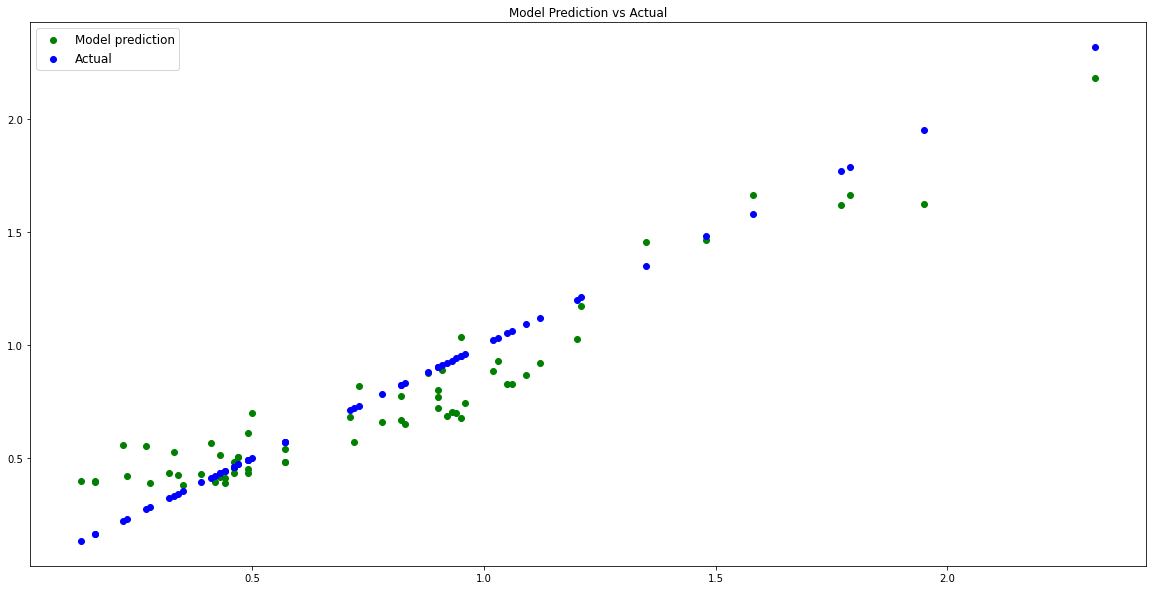

In [39]:
print("Simple forecasting model")
rmse = np.sqrt(mean_squared_error(df_all[target_column_name], df_all['predicted']))
print("[Test Data] \nRoot Mean squared error: %.3f" % rmse)
mae = mean_absolute_error(df_all[target_column_name], df_all['predicted'])
print('mean_absolute_error score: %.3f' % mae)
print('MAPE: %.3f' % MAPE(df_all[target_column_name], df_all['predicted']))

# Plot outputs
%matplotlib inline
plt.figure(figsize=(20, 10))
plt.title('Model Prediction vs Actual')
test_pred = plt.scatter(df_all[target_column_name], df_all['predicted'], color='green')
test_test = plt.scatter(y_test, y_test, color='blue')
plt.legend((test_pred, test_test), ('Model prediction', 'Actual'), loc='upper left', fontsize=12)
plt.show()

In [40]:
df_all.groupby('horizon_origin').apply(
    lambda df: pd.Series({'MAPE': MAPE(df[target_column_name], df['predicted']),
                          'RMSE': np.sqrt(mean_squared_error(df[target_column_name], df['predicted'])),
                          'MAE': mean_absolute_error(df[target_column_name], df['predicted'])}))

,MAPE,RMSE,MAE
horizon_origin,,,
1,31.94,0.17,0.14
2,59.92,0.22,0.20
3,21.26,0.11,0.09
4,22.61,0.14,0.13
5,29.10,0.18,0.18
6,8.70,0.06,0.06
7,11.93,0.10,0.10
8,8.29,0.06,0.05
9,6.13,0.10,0.08


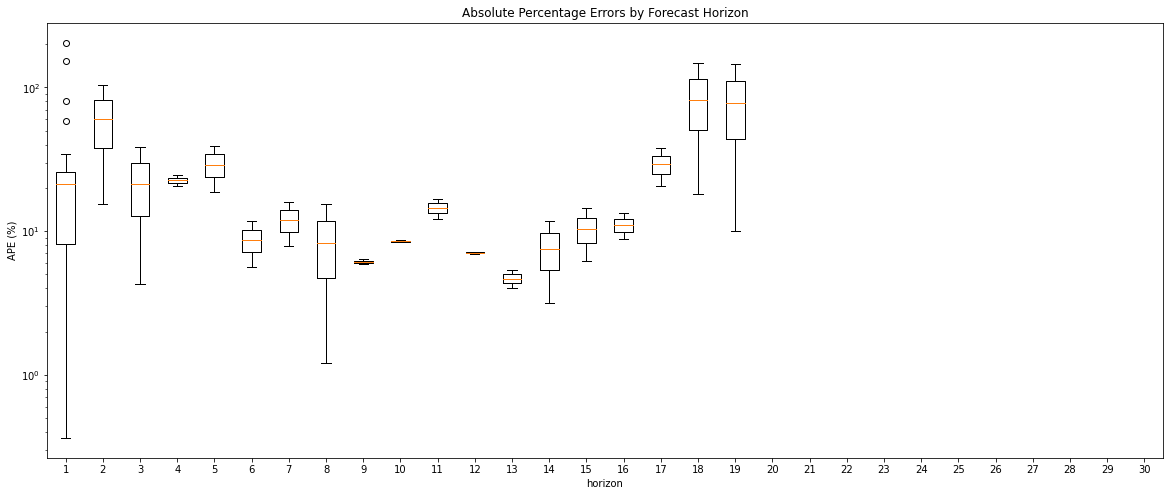

In [41]:
df_all_APE = df_all.assign(APE=APE(df_all[target_column_name], df_all['predicted']))
APEs = [df_all_APE[df_all['horizon_origin'] == h].APE.values for h in range(1, max_horizon + 1)]

%matplotlib inline
plt.figure(figsize=(20, 8))
plt.boxplot(APEs)
plt.yscale('log')
plt.xlabel('horizon')
plt.ylabel('APE (%)')
plt.title('Absolute Percentage Errors by Forecast Horizon')

plt.show()

Simple forecasting model
[Test Data] 
Root Mean squared error: 0.154
mean_absolute_error score: 0.127
MAPE: 27.045


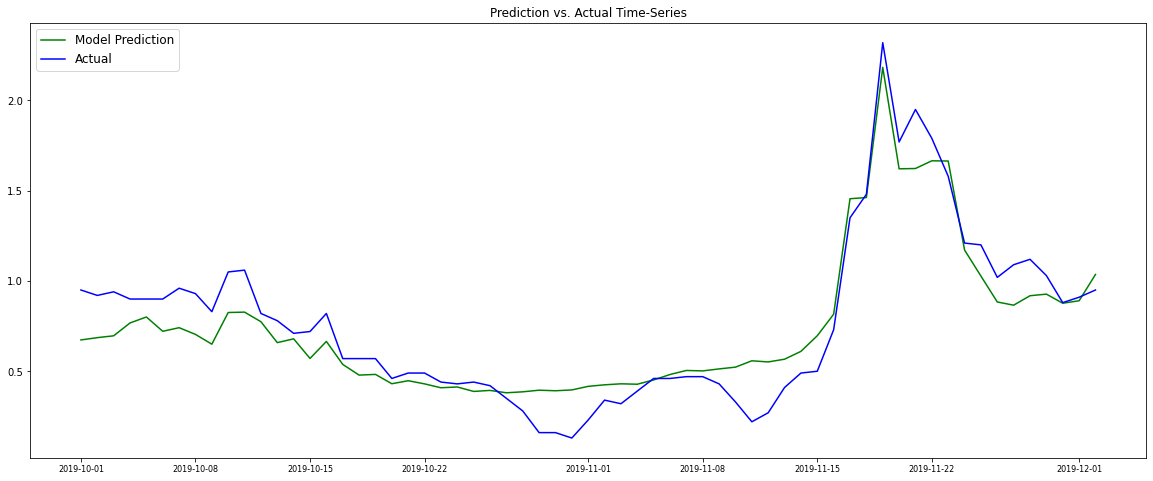

In [42]:
print("Simple forecasting model")
rmse = np.sqrt(mean_squared_error(df_all[target_column_name], df_all['predicted']))
print("[Test Data] \nRoot Mean squared error: %.3f" % rmse)
mae = mean_absolute_error(df_all[target_column_name], df_all['predicted'])
print('mean_absolute_error score: %.3f' % mae)
print('MAPE: %.3f' % MAPE(df_all[target_column_name], df_all['predicted']))

# Plot outputs
%matplotlib inline
plt.figure(figsize=(20, 8))
pred, = plt.plot(df_all[time_column_name], df_all['predicted'], color='green')
actual, = plt.plot(df_all[time_column_name], df_all[target_column_name], color='blue')
plt.xticks(fontsize=8)
plt.legend((pred, actual), ('Model Prediction', 'Actual'), loc='upper left', fontsize=12)
plt.title('Prediction vs. Actual Time-Series')

plt.show()

In [43]:
# Prediction
df_all.head(100)

,Date,_automl_dummy_grain_col,origin,predicted,horizon_origin,Vent,Humidite,NO_Monoxyde_azote,NOX_Oxyde_azote,O3_Ozone,Poussieres,SO2_Dioxyde_de_soufre,Temperature,Direction_vent,CO2
0,2019-10-01,_automl_dummy_grain_col,2019-09-30,0.67,1,130.29,55.69,23.93,52.25,2.81,44.43,26.82,2.18,4.42,0.95
1,2019-10-02,_automl_dummy_grain_col,2019-10-01,0.69,1,135.03,56.59,26.37,54.20,1.83,45.41,26.47,1.76,4.00,0.92
2,2019-10-03,_automl_dummy_grain_col,2019-10-02,0.70,1,136.22,57.69,28.81,56.15,1.83,45.90,26.11,1.41,3.96,0.94
3,2019-10-04,_automl_dummy_grain_col,2019-10-03,0.77,1,129.76,58.67,39.55,67.87,1.59,45.41,26.82,1.00,3.92,0.90
4,2019-10-05,_automl_dummy_grain_col,2019-10-04,0.80,1,133.45,60.03,44.92,74.22,1.22,43.46,27.18,0.53,3.41,0.90
5,2019-10-06,_automl_dummy_grain_col,2019-10-05,0.72,1,123.56,60.62,35.16,62.99,1.10,41.99,26.82,0.28,3.45,0.90
6,2019-10-07,_automl_dummy_grain_col,2019-10-06,0.74,1,124.75,62.77,40.53,67.87,1.22,41.26,25.39,-0.40,3.08,0.96
7,2019-10-08,_automl_dummy_grain_col,2019-10-07,0.70,1,124.48,63.06,34.67,62.50,1.34,39.31,26.47,-0.44,2.91,0.93
8,2019-10-09,_automl_dummy_grain_col,2019-10-08,0.65,1,119.08,63.45,29.30,55.18,1.00,37.84,25.75,-0.51,2.96,0.83
9,2019-10-10,_automl_dummy_grain_col,2019-10-09,0.83,1,120.40,67.55,57.62,84.96,1.00,36.38,26.11,-1.49,1.96,1.05


## 5. AutoML Forecasting with lags


<img src="https://azurecomcdn.azureedge.net/mediahandler/acomblog/media/Default/blog/80748202-8fef-4d74-b8b1-bdd27e6838aa.png">

### Lags parameter

<img src="https://azurecomcdn.azureedge.net/mediahandler/acomblog/media/Default/blog/6690a165-f602-4c2e-ba5d-24437505ef69.png">

### Target Rolling Windows Size parameter

<img src="https://azurecomcdn.azureedge.net/mediahandler/acomblog/media/Default/blog/d03d6941-a7b8-4023-a4ab-d8f56751bfe4.png">

In [44]:
time_series_settings_with_lags = {
    'time_column_name': time_column_name,
    'max_horizon': max_horizon,
    'country_or_region': 'FR',
    'target_lags': 10,
    'target_rolling_window_size': 30
}

automl_config_lags = AutoMLConfig(task='forecasting',
                                  debug_log='automlwork42.log',
                                  primary_metric='normalized_root_mean_squared_error',
                                  iterations=5,
                                  iteration_timeout_minutes=10,
                                  enable_voting_ensemble=False,
                                  enable_stack_ensemble=False,
                                  X=X_train,
                                  y=y_train,
                                  n_cross_validations=3,
                                  path=project_folder,
                                  verbosity=logging.INFO,
                                  **time_series_settings_with_lags)

WARNING - The AutoMLConfig inputs you have specified will soon be deprecated. Please use the AutoMLConfig shown in our documentation: https://aka.ms/AutoMLConfig


In [45]:
%%time
local_run_lags = experiment.submit(automl_config_lags, show_output=True)

Running on local machine
Parent Run ID: AutoML_7bf68c86-023e-4133-af84-a99a889a5c81

Current status: DatasetFeaturization. Beginning to featurize the dataset.


WARNING - Converting non-string tag to string: (forecasting_target_lags: [10])
WARNING - Converting non-string tag to string: (forecasting_target_rolling_window_size: 30)
WARNING - Converting non-string tag to string: (forecasting_max_horizon: 30)


Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Frequency detection
STATUS:       PASSED
DESCRIPTION:  The time series was analyzed, all data points are aligned with detected frequency.

TYPE:         Memory Issues Detection
STATUS:       PASSED
DESCRIPTION:  The se

In [46]:
local_run_lags

Experiment,Id,Type,Status,Details Page,Docs Page
Exemple4-automlforecast,AutoML_7bf68c86-023e-4133-af84-a99a889a5c81,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [47]:
from azureml.widgets import RunDetails
RunDetails(local_run_lags).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

In [48]:
children = list(local_run_lags.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4
explained_variance,0.33,0.36,0.26,0.34,0.10
mean_absolute_error,0.14,0.18,0.15,0.14,0.64
mean_absolute_percentage_error,54.39,37.76,54.40,54.46,222.27
median_absolute_error,0.13,0.18,0.15,0.13,0.57
normalized_mean_absolute_error,0.02,0.03,0.02,0.02,0.10
normalized_median_absolute_error,0.02,0.03,0.02,0.02,0.09
normalized_root_mean_squared_error,0.03,0.03,0.03,0.03,0.10
normalized_root_mean_squared_log_error,0.06,0.08,0.06,0.06,0.21
r2_score,0.28,-0.25,0.25,0.29,-1.00
root_mean_squared_error,0.16,0.22,0.17,0.16,0.67


In [49]:
best_run, fitted_model = local_run_lags.get_output()
fitted_model.steps

[('timeseriestransformer',
  TimeSeriesTransformer(featurization_config=None, logger=None,
             pipeline_type=<TimeSeriesPipelineType.FULL: 1>)),
 ('StandardScalerWrapper',
  <azureml.automl.runtime.shared.model_wrappers.StandardScalerWrapper at 0x7f2a617d9ef0>),
 ('ElasticNet',
  ElasticNet(alpha=0.8948421052631579, copy_X=True, fit_intercept=True,
        l1_ratio=0.4268421052631579, max_iter=1000, normalize=False,
        positive=False, precompute=False, random_state=None,
        selection='cyclic', tol=0.0001, warm_start=False))]

In [50]:
fitted_model.get_params

<bound method Pipeline.get_params of ForecastingPipelineWrapper(pipeline=Pipeline(memory=None,
     steps=[('timeseriestransformer', TimeSeriesTransformer(featurization_config=None, logger=None,
           pipeline_type=<TimeSeriesPipelineType.FULL: 1>)), ('StandardScalerWrapper', <azureml.automl.runtime.shared.model_wrappers.StandardScalerWrapper object at 0x7f2a617d9ef0>), ('ElasticNet', Elastic...alse, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False))]),
              stddev=None)>

In [51]:
fitted_model.steps

[('timeseriestransformer',
  TimeSeriesTransformer(featurization_config=None, logger=None,
             pipeline_type=<TimeSeriesPipelineType.FULL: 1>)),
 ('StandardScalerWrapper',
  <azureml.automl.runtime.shared.model_wrappers.StandardScalerWrapper at 0x7f2a617d9ef0>),
 ('ElasticNet',
  ElasticNet(alpha=0.8948421052631579, copy_X=True, fit_intercept=True,
        l1_ratio=0.4268421052631579, max_iter=1000, normalize=False,
        positive=False, precompute=False, random_state=None,
        selection='cyclic', tol=0.0001, warm_start=False))]

In [52]:
fitted_model.named_steps['timeseriestransformer'].get_engineered_feature_names()

['Direction_vent',
 'Direction_vent_WASNULL',
 'Humidite',
 'Humidite_WASNULL',
 'NOX_Oxyde_azote',
 'NOX_Oxyde_azote_WASNULL',
 'NO_Monoxyde_azote',
 'NO_Monoxyde_azote_WASNULL',
 'O3_Ozone',
 'O3_Ozone_WASNULL',
 'Poussieres',
 'Poussieres_WASNULL',
 'SO2_Dioxyde_de_soufre',
 'SO2_Dioxyde_de_soufre_WASNULL',
 'Temperature',
 'Temperature_WASNULL',
 'Vent',
 'Vent_WASNULL',
 'horizon_origin',
 '_automl_target_col_lag10D',
 '_automl_target_col_min_window30D',
 '_automl_target_col_max_window30D',
 '_automl_target_col_mean_window30D',
 'half',
 'quarter',
 'month',
 'day',
 'wday',
 'qday',
 '_IsPaidTimeOff',
 '_Holiday_1 day after Armistice 1945',
 '_Holiday_1 day after Ascension',
 '_Holiday_1 day after Assomption',
 '_Holiday_1 day after Fête du Travail',
 '_Holiday_1 day after Fête nationale',
 "_Holiday_1 day after Jour de l'an",
 '_Holiday_1 day after Lundi de Pentecôte',
 '_Holiday_1 day after Lundi de Pâques',
 '_Holiday_1 day before Armistice 1945',
 '_Holiday_1 day before Ascension',
 '_Holiday_1 day before Assomption',
 '_Holiday_1 day before Fête du Travail',
 '_Holiday_1 day before Fête nationale',
 '_Holiday_1 day before Lundi de Pentecôte',
 '_Holiday_1 day before Lundi de Pâques',
 '_Holiday_2 days after Armistice 1945',
 '_Holiday_2 days after Ascension',
 '_Holiday_2 days after Assomption',
 '_Holiday_2 days after Fête du Travail',
 '_Holiday_2 days after Fête nationale',
 "_Holiday_2 days after Jour de l'an",
 '_Holiday_2 days after Lundi de Pentecôte',
 '_Holiday_2 days after Lundi de Pâques',
 '_Holiday_2 days before Armistice 1945',
 '_Holiday_2 days before Ascension',
 '_Holiday_2 days before Assomption',
 '_Holiday_2 days before Fête du Travail',
 '_Holiday_2 days before Fête nationale',
 '_Holiday_2 days before Lundi de Pentecôte',
 '_Holiday_2 days before Lundi de Pâques',
 '_Holiday_3 days after Armistice 1945',
 '_Holiday_3 days after Lundi de Pâques',
 '_Holiday_3 days before Armistice 1945',
 '_Holiday_3 days before Lundi de Pâques',
 '_Holiday_4 days after Armistice 1945',
 '_Holiday_4 days after Lundi de Pâques',
 '_Holiday_4 days before Armistice 1945',
 '_Holiday_4 days before Lundi de Pâques',
 '_Holiday_5 days after Armistice 1945',
 '_Holiday_5 days after Lundi de Pâques',
 '_Holiday_5 days before Lundi de Pâques',
 '_Holiday_Armistice 1945',
 '_Holiday_Ascension',
 '_Holiday_Assomption',
 '_Holiday_Fête du Travail',
 '_Holiday_Fête nationale',
 "_Holiday_Jour de l'an",
 '_Holiday_Lundi de Pentecôte',
 '_Holiday_Lundi de Pâques']

In [53]:
df_all2 = do_rolling_forecast(fitted_model, X_test, y_test, max_horizon)

Simple forecasting model
[Test Data] 
Root Mean squared error: 0.153
mean_absolute_error score: 0.125
MAPE: 26.981


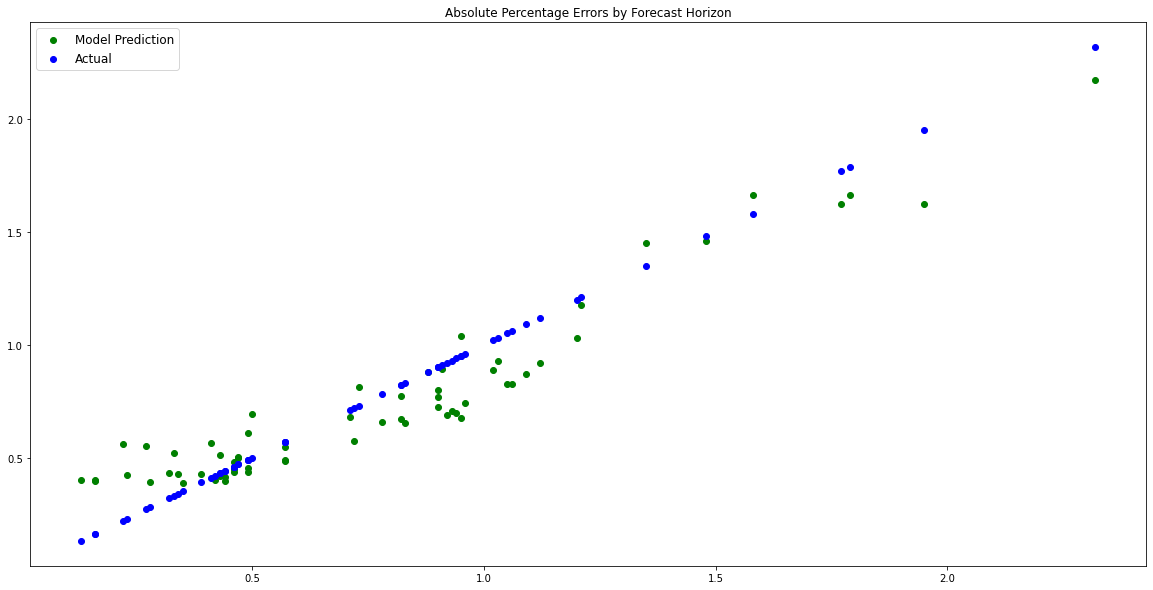

In [54]:
print("Simple forecasting model")
rmse = np.sqrt(mean_squared_error(df_all2[target_column_name], df_all2['predicted']))
print("[Test Data] \nRoot Mean squared error: %.3f" % rmse)
mae = mean_absolute_error(df_all2[target_column_name], df_all2['predicted'])
print('mean_absolute_error score: %.3f' % mae)
print('MAPE: %.3f' % MAPE(df_all2[target_column_name], df_all2['predicted']))

# Plot outputs
%matplotlib inline
plt.figure(figsize=(20, 10))
plt.title('Absolute Percentage Errors by Forecast Horizon')
test_pred = plt.scatter(df_all2[target_column_name], df_all2['predicted'], color='green')
test_test = plt.scatter(y_test, y_test, color='blue')
plt.legend((test_pred, test_test), ('Model Prediction', 'Actual'), loc='upper left', fontsize=12)
plt.show()

In [55]:
df_all2.groupby('horizon_origin').apply(
    lambda df: pd.Series({'MAPE': MAPE(df[target_column_name], df['predicted']),
                          'RMSE': np.sqrt(mean_squared_error(df[target_column_name], df['predicted'])),
                          'MAE': mean_absolute_error(df[target_column_name], df['predicted'])}))


df_all2_APE = df_all2.assign(APE=APE(df_all2[target_column_name], df_all2['predicted']))
APEs = [df_all2_APE[df_all2['horizon_origin'] == h].APE.values for h in range(1, max_horizon + 1)]

Simple forecasting model
[Test Data] 
Root Mean squared error: 0.153
mean_absolute_error score: 0.125
MAPE: 26.981


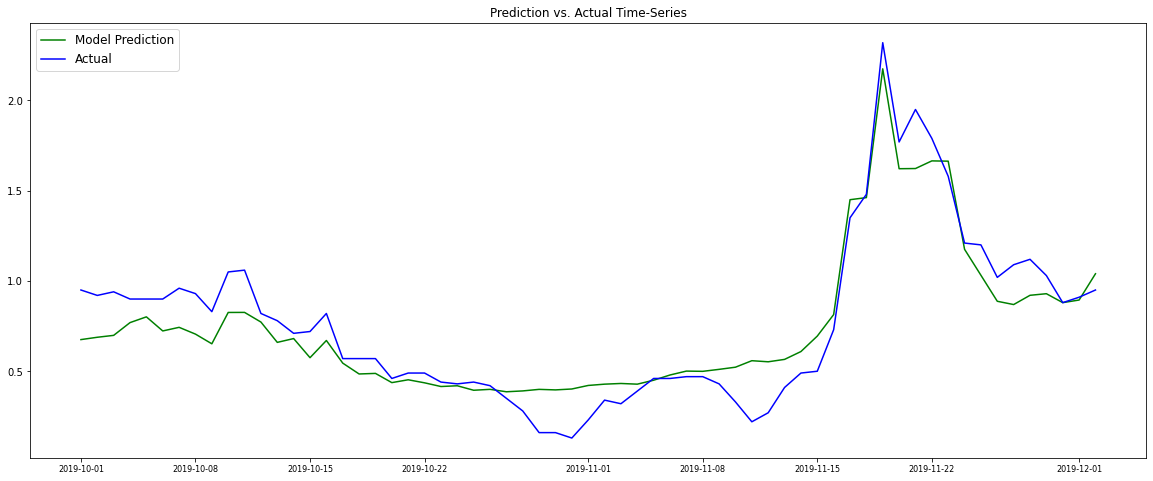

In [56]:
print("Simple forecasting model")
rmse = np.sqrt(mean_squared_error(df_all2[target_column_name], df_all2['predicted']))
print("[Test Data] \nRoot Mean squared error: %.3f" % rmse)
mae = mean_absolute_error(df_all2[target_column_name], df_all2['predicted'])
print('mean_absolute_error score: %.3f' % mae)
print('MAPE: %.3f' % MAPE(df_all2[target_column_name], df_all2['predicted']))

# Plot outputs
%matplotlib inline
plt.figure(figsize=(20, 8))
pred, = plt.plot(df_all2[time_column_name], df_all2['predicted'], color='green')
actual, = plt.plot(df_all2[time_column_name], df_all2[target_column_name], color='blue')
plt.xticks(fontsize=8)
plt.legend((pred, actual), ('Model Prediction', 'Actual'), loc='upper left', fontsize=12)
plt.title('Prediction vs. Actual Time-Series')

plt.show()

In [57]:
df_all2_APE.tail(10)

,Date,_automl_dummy_grain_col,origin,predicted,horizon_origin,Vent,Humidite,NO_Monoxyde_azote,NOX_Oxyde_azote,O3_Ozone,Poussieres,SO2_Dioxyde_de_soufre,Temperature,Direction_vent,CO2,APE
53,2019-11-23,_automl_dummy_grain_col,2019-10-30,1.66,24,108.93,70.36,177.25,211.43,1.59,53.96,26.11,2.22,2.45,1.58,5.30
54,2019-11-24,_automl_dummy_grain_col,2019-10-30,1.18,25,113.02,69.58,104.00,135.74,0.98,51.03,22.89,2.41,2.42,1.21,2.85
55,2019-11-25,_automl_dummy_grain_col,2019-10-30,1.03,26,123.83,70.04,83.50,114.26,1.22,49.07,21.46,2.27,2.37,1.20,14.03
56,2019-11-26,_automl_dummy_grain_col,2019-10-30,0.89,27,131.87,70.17,63.96,93.75,1.00,44.68,20.39,2.29,2.57,1.02,12.98
57,2019-11-27,_automl_dummy_grain_col,2019-10-30,0.87,28,125.67,70.97,62.50,92.29,1.00,41.99,21.10,2.02,2.09,1.09,20.24
58,2019-11-28,_automl_dummy_grain_col,2019-10-30,0.92,29,129.36,73.36,71.78,101.56,1.22,40.53,22.18,1.41,1.83,1.12,17.80
59,2019-11-29,_automl_dummy_grain_col,2019-10-30,0.93,30,132.00,73.10,74.22,103.03,1.34,41.02,21.10,1.64,2.29,1.03,9.76
60,2019-11-30,_automl_dummy_grain_col,2019-11-29,0.88,1,131.34,73.66,66.41,95.21,1.34,41.26,21.10,1.44,1.84,0.88,0.01
61,2019-12-01,_automl_dummy_grain_col,2019-11-29,0.89,2,127.65,74.85,68.36,96.68,1.22,42.72,22.53,1.13,1.58,0.91,1.71
62,2019-12-02,_automl_dummy_grain_col,2019-11-29,1.04,3,114.99,75.68,89.84,119.63,1.59,44.43,22.53,0.90,1.61,0.95,9.48


> **Get started with time-series forecasting in automated ML.** With these new capabilities automated ML increases support more complex forecasting scenarios, provides more control to configure training data using lags and window aggregation and improves accuracy with new holiday featurization and ROCV. Azure Machine Learning aims to enable data scientists of all skill levels to use powerful machine learning technology that simplifies their processes and reduces the time spent training models. Get started by visiting our documentation and let us know what you think - we are committed to make automated ML better for you!

In [58]:
best_run, fitted_model = local_run.get_output()
print(best_run)
print()
print(fitted_model)
print()
best_run_metrics = best_run.get_metrics()
for metric_name in best_run_metrics:
    metric = best_run_metrics[metric_name]
    print(metric_name, metric)

Run(Experiment: Exemple4-automlforecast,
Id: AutoML_825cf827-e15d-4303-b8c8-7a824ffbe948_3,
Type: None,
Status: Completed)

ForecastingPipelineWrapper(pipeline=Pipeline(memory=None,
     steps=[('timeseriestransformer', TimeSeriesTransformer(featurization_config=None, logger=None,
           pipeline_type=<TimeSeriesPipelineType.FULL: 1>)), ('StandardScalerWrapper', <azureml.automl.runtime.shared.model_wrappers.StandardScalerWrapper object at 0x7f29382a9048>), ('ElasticNet', Elastic...alse, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False))]),
              stddev=None)

root_mean_squared_error 0.1660485900537533
root_mean_squared_log_error 0.12140265642488274
mean_absolute_error 0.13998201092977014
mean_absolute_percentage_error 55.27925700049892
explained_variance 0.33866028646508894
normalized_root_mean_squared_error 0.025273757999049212
predicted_true aml://artifactId/ExperimentRun/dcid.AutoML_825cf827-e15d-4303-b8c8-7a824ffbe948_3/predict

In [59]:
from azureml.core import Model

best_run.register_model(model_path='outputs/model.pkl', model_name='Exemple4-AutoML-Forecast',
                        tags={'Training context':'Azure Auto ML'},
                        properties={'R2': best_run_metrics['r2_score'], 'RMSE': best_run_metrics['normalized_root_mean_squared_error']})

Model(workspace=Workspace.create(name='workshopAML2020', subscription_id='70b8f39e-8863-49f7-b6ba-34a80799550c', resource_group='workshopAML2020-rg'), name=Exemple4-AutoML-Forecast, id=Exemple4-AutoML-Forecast:6, version=6, tags={'Training context': 'Azure Auto ML'}, properties={'R2': '0.27268956675549244', 'RMSE': '0.025273757999049212'})

In [60]:
# Liste des modèles référencés
for model in Model.list(ws):
    print(model.name, 'version =', model.version)
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print ('\t',tag_name, ':', tag)
    for prop_name in model.properties:
        prop = model.properties[prop_name]
        print ('\t',prop_name, ':', prop)
    print('\n')

Exemple4-AutoML-Forecast version = 6
	 Training context : Azure Auto ML
	 R2 : 0.27268956675549244
	 RMSE : 0.025273757999049212


Exemple3-AutoML-Regression version = 10
	 Training context : Azure Auto ML
	 R2 : 0.8609905269903366
	 RMSE : 0.07272566334894777


mybestmodel version = 7
	 Training context : Azure Auto ML
	 AUC : 0.9993169930532767
	 Accuracy : 0.9658275743456644


RegressionRidge version = 8
	 area : Diabetes
	 type : Regression Ridge
	 k : 0.4
	 MSE : 3295.741064355809
	 R2 : 0.3572956390661659
	 Framework : Azure ML


IBM_attrition_explainer version = 11


local_deploy_model version = 11


boston_model.pkl version = 15
	 algo : Regression
	 Training context : Azure ML
	 Framework : scikit-learn


Exemple10-Modele-TensorFlow version = 17
	 Framework : TensorFlow
	 Hyperdrive : Oui
	 GPU : Oui


diabetes_model version = 16
	 Training context : Pipeline


Modele-SKLEARN-Regression version = 3
	 area : diabetes
	 type : regression
	 format : Scikit-Learn pkl


mybestmodel

> Documentation : https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-automated-ml<br>
https://docs.microsoft.com/en-us/azure/machine-learning/how-to-configure-auto-train

<img src="https://github.com/retkowsky/images/blob/master/Powered-by-MS-Azure-logo-v2.png?raw=true" height="300" width="300">